## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [5]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Fri Apr 05 14:37:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8    N/A /  N/A |     69MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
import os
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from numba import cuda
import itertools

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [24]:
import tensorflow as tf
import keras.backend as K

def combined_loss(gamma=2., alpha=4., ce_weight=0.7, fcl_weight=0.3):
    
    gamma, alpha = float(gamma), float(alpha)
    
    def ce_focal_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        f1 = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_f1 = tf.reduce_max(f1, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weight * ce_loss) + (fcl_weight * tf.reduce_mean(reduced_f1))
    
    
    return ce_focal_loss


ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [25]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, amsgrad=True)
    
    model.compile(loss=combined_loss(ce_weight=ce_w, fcl_weight=1. - ce_w),
                  metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128) 

Epoch 48/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0225 - acc: 0.9964 - val_loss: 6.6963 - val_acc: 0.5287
Epoch 49/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.0102 - acc: 0.9990 - val_loss: 6.7720 - val_acc: 0.5285
Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.0047 - acc: 0.9999 - val_loss: 6.7632 - val_acc: 0.5273
Numbers of exp: 1, ce_weight: 0.30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 

Epoch 45/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 6.3609 - val_acc: 0.5477
Epoch 46/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 6.4337 - val_acc: 0.5475
Epoch 47/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 6.4731 - val_acc: 0.5491
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 6.5292 - val_acc: 0.5471
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 6.5812 - val_acc: 0.5479
Epoch 50/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 6.6237 - val_acc: 0.5477
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input

Epoch 42/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.2232 - acc: 0.9429 - val_loss: 5.5102 - val_acc: 0.5133
Epoch 43/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.2200 - acc: 0.9437 - val_loss: 5.3984 - val_acc: 0.5143
Epoch 44/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.1541 - acc: 0.9609 - val_loss: 5.2488 - val_acc: 0.5124
Epoch 45/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.1160 - acc: 0.9715 - val_loss: 5.1751 - val_acc: 0.5277
Epoch 46/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0766 - acc: 0.9817 - val_loss: 5.3233 - val_acc: 0.5207
Epoch 47/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0449 - acc: 0.9920 - val_loss: 5.3060 - val_acc: 0.5262
Epoch 48/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.0222 - acc: 0.9976 - val_loss: 5.3487 - val_acc: 0.5297
Epoch 49/50
50000/50000 [=========

Epoch 39/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.2068 - acc: 0.9429 - val_loss: 4.2823 - val_acc: 0.5167
Epoch 40/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.1267 - acc: 0.9670 - val_loss: 4.2737 - val_acc: 0.5191
Epoch 41/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0647 - acc: 0.9860 - val_loss: 4.3237 - val_acc: 0.5297
Epoch 42/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0344 - acc: 0.9947 - val_loss: 4.3388 - val_acc: 0.5319
Epoch 43/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0183 - acc: 0.9985 - val_loss: 4.4309 - val_acc: 0.5374
Epoch 44/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0133 - acc: 0.9991 - val_loss: 4.4879 - val_acc: 0.5370
Epoch 45/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0091 - acc: 0.9996 - val_loss: 4.5520 - val_acc: 0.5353
Epoch 46/50
50000/50000 [=========

Epoch 36/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0601 - acc: 0.9807 - val_loss: 3.0761 - val_acc: 0.5224
Epoch 37/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0702 - acc: 0.9770 - val_loss: 3.1336 - val_acc: 0.5165
Epoch 38/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.0837 - acc: 0.9713 - val_loss: 3.1064 - val_acc: 0.5181
Epoch 39/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0922 - acc: 0.9691 - val_loss: 3.1802 - val_acc: 0.5095
Epoch 40/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0956 - acc: 0.9669 - val_loss: 3.0835 - val_acc: 0.5215
Epoch 41/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.0782 - acc: 0.9739 - val_loss: 3.1170 - val_acc: 0.5174
Epoch 42/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.0622 - acc: 0.9789 - val_loss: 3.1894 - val_acc: 0.5229
Epoch 43/50
50000/50000 [=========

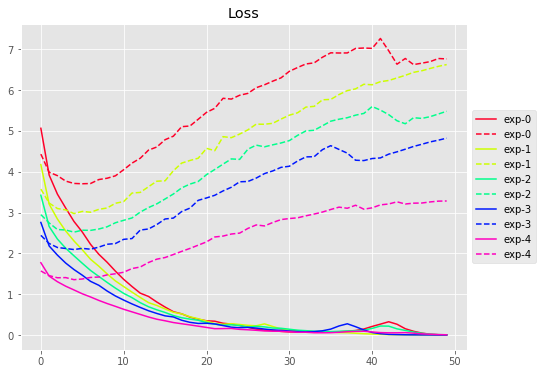

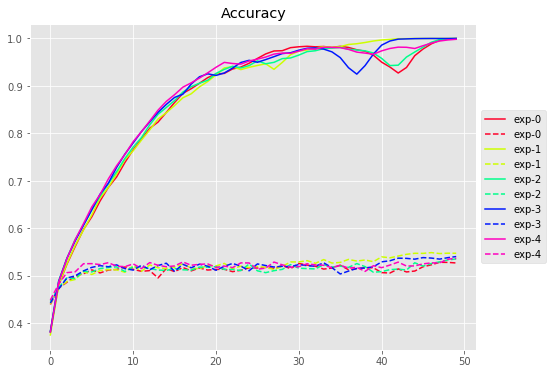

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()